In [100]:
import pandas as pd
from matplotlib import pyplot as plt 
import pyarrow.parquet as pa
import seaborn as sns
from scipy import stats
import numpy as np

In [64]:
table = pa.read_table('all_data.parquet')
table.shape

(519766, 28)

In [108]:
df = table.to_pandas()

In [68]:
columns = df.columns
df.columns

Index(['Время', 'Мощность МПСИ ', 'Мощность МШЦ ', 'Ток МПСИ ', 'Ток МШЦ ',
       'Питание МПСИ ', 'Возврат руды МПСИ ', 'Расход воды МПСИ  PV',
       'Расход воды МПСИ 2 PV', 'Расход воды МПСИ  SP',
       'Расход воды МПСИ 2 SP', 'Расход воды МПСИ  CV',
       'Расход воды МПСИ 2 CV', 'факт соотношение руда/вода МПСИ ',
       'Давление на подшипник МПСИ  загрузка',
       'Давление на подшипник МПСИ 2 загрузка',
       'Давление на подшипник МПСИ  разгрузка',
       'Давление на подшипник МПСИ 2 разгрузка', 'Расход оборотной воды ',
       'pH оборотной воды', 't оборотной воды', 'Гранулометрия ', 'Поток ',
       'Расход воды МПСИ 1 PV', 'Расход воды МПСИ 1 SP',
       'Расход воды МПСИ 1 CV', 'Давление на подшипник МПСИ 1 загрузка',
       'Давление на подшипник МПСИ 1 разгрузка'],
      dtype='object')

##  Предобработка данных

Text(0.5, 1.0, 'Корреляция параметров')

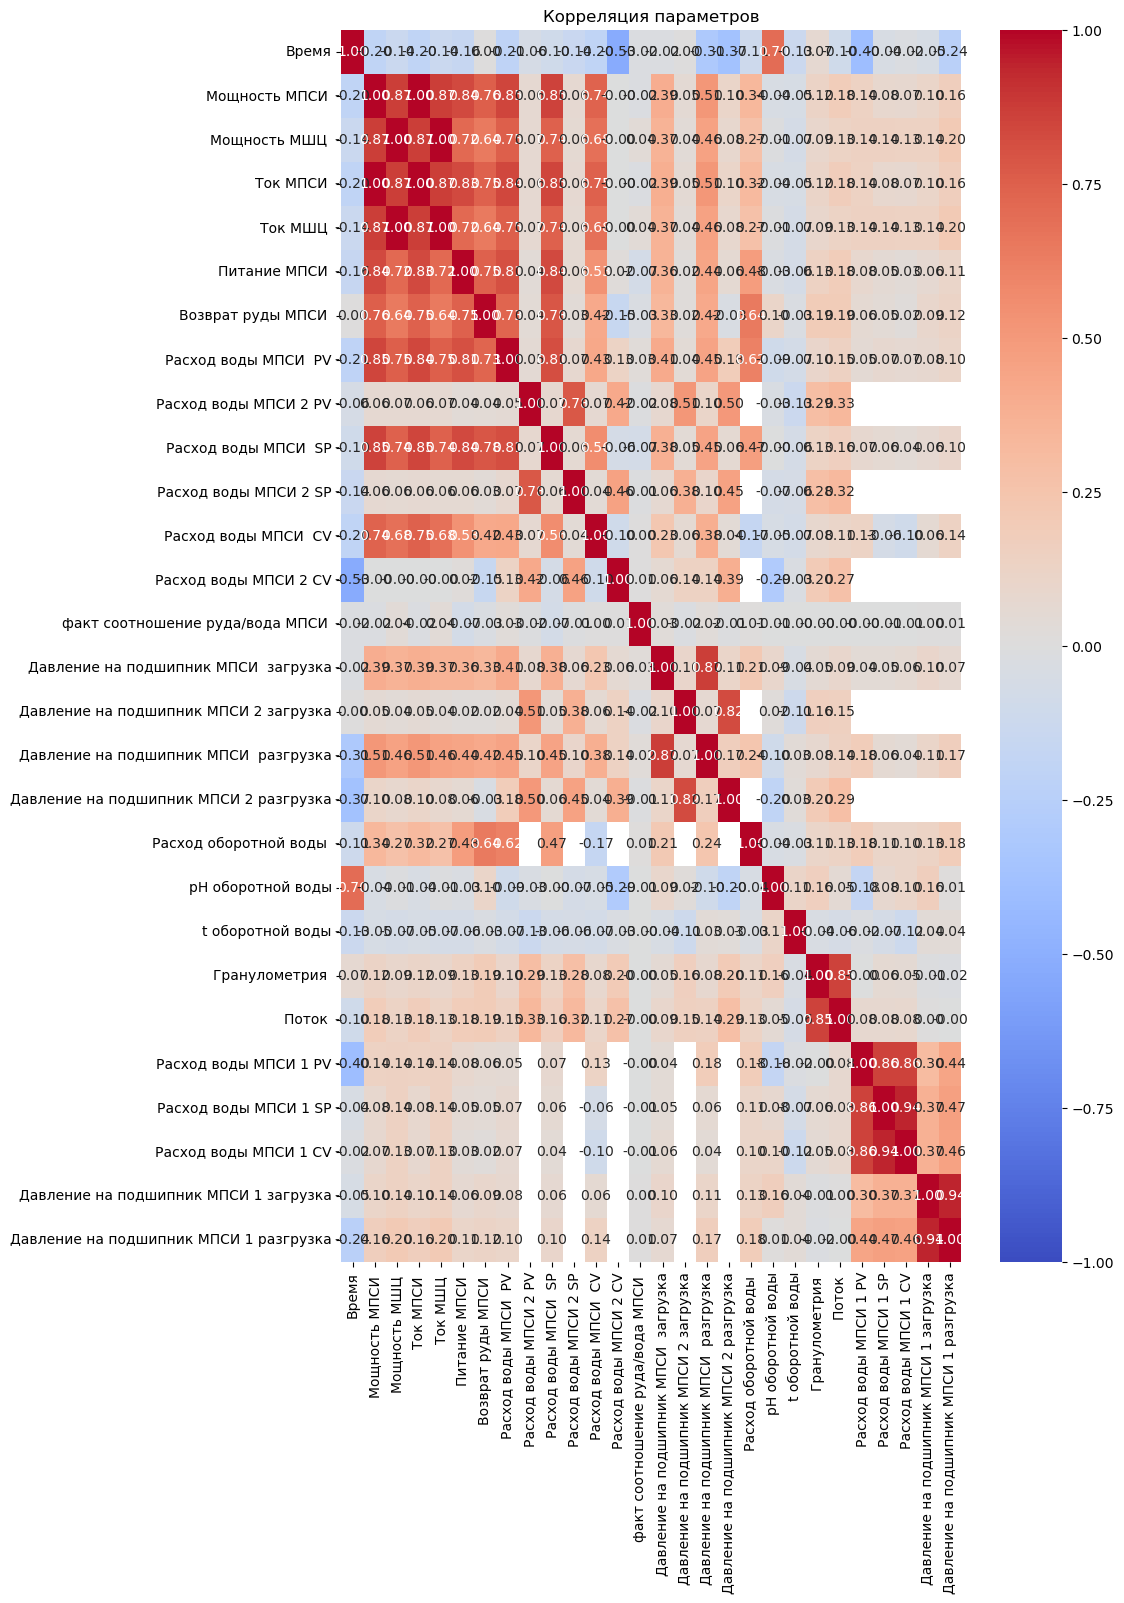

In [86]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 16))

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1)        

plt.title('Корреляция параметров')

### 1. Количество пустых значений в начальном датасете

In [23]:
df.isna().sum(axis=0)

Время                                          0
Мощность МПСИ                                 32
Мощность МШЦ                                  32
Ток МПСИ                                      32
Ток МШЦ                                       32
Питание МПСИ                                  32
Возврат руды МПСИ                             32
Расход воды МПСИ  PV                          32
Расход воды МПСИ 2 PV                     259899
Расход воды МПСИ  SP                          32
Расход воды МПСИ 2 SP                     259899
Расход воды МПСИ  CV                          32
Расход воды МПСИ 2 CV                     259899
факт соотношение руда/вода МПСИ               32
Давление на подшипник МПСИ  загрузка          32
Давление на подшипник МПСИ 2 загрузка     259899
Давление на подшипник МПСИ  разгрузка         32
Давление на подшипник МПСИ 2 разгрузка    259899
Расход оборотной воды                         32
pH оборотной воды                             32
t оборотной воды    

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 16))

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1)        

plt.title('Корреляция параметров')


### Количество пропусков в датафрейме

<BarContainer object of 28 artists>

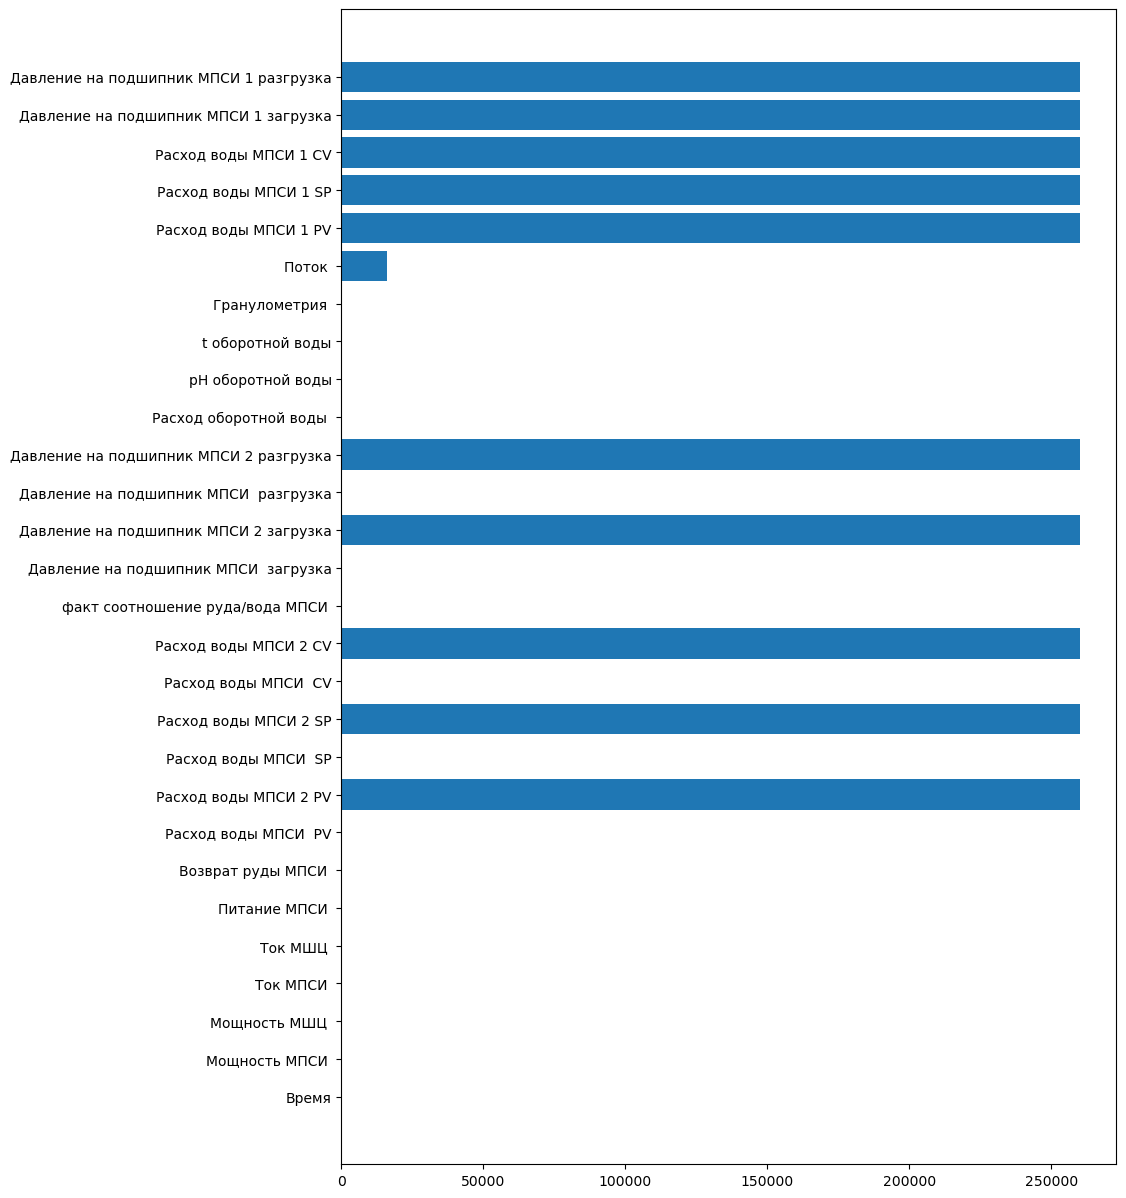

In [ ]:
nan_data = df.isna().sum(axis=0)

fig, ax = plt.subplots(figsize=(10, 15)) 

ax.barh(nan_data.index, nan_data.values)

### Удаляем столбцы с данными, которые не имеют сильного влияния на остальные параметры и имеют множество пропусков

In [127]:
columns_to_drop = [
    'Расход воды МПСИ 2 PV',
    'Расход воды МПСИ 2 SP',
    'Расход воды МПСИ 2 CV',
    'факт соотношение руда/вода МПСИ ',
    'Давление на подшипник МПСИ 2 загрузка',
    'Давление на подшипник МПСИ 2 разгрузка',
    'Расход оборотной воды ',
    'pH оборотной воды',
    't оборотной воды',
]

cln_df = df.drop(columns=columns_to_drop)

# Анализ Потока

### Поток (16051 пропущенных значений) - можно попробовать восстановить c помощью медианы

In [128]:
df['Поток ']
cln_df['Поток '] = cln_df['Поток '].fillna(cln_df['Поток '].median())

In [129]:
cln_df = cln_df.dropna()

### Создаем подграфики для разных типов визуализации

Text(0, 0.5, 'Значение потока')

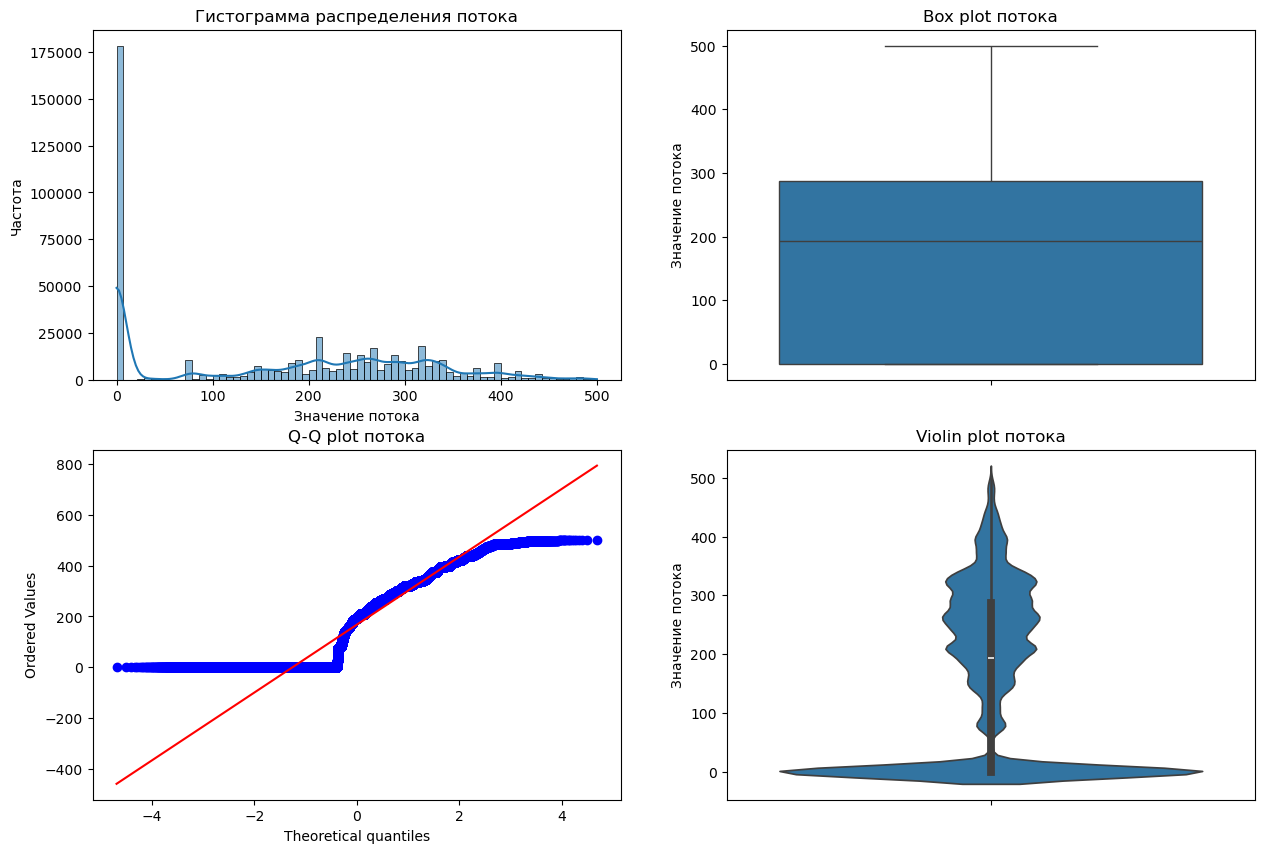

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Гистограмма с кривой плотности
sns.histplot(data=df, x='Поток ', kde=True, ax=axes[0,0])
axes[0,0].set_title('Гистограмма распределения потока')
axes[0,0].set_xlabel('Значение потока')
axes[0,0].set_ylabel('Частота')

# (Box plot)
sns.boxplot(data=df, y='Поток ', ax=axes[0,1])
axes[0,1].set_title('Box plot потока')
axes[0,1].set_ylabel('Значение потока')

# QQ-plot для проверки на нормальность
stats.probplot(df['Поток '].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q plot потока')

# Violin plot
sns.violinplot(data=df, y='Поток ', ax=axes[1,1])
axes[1,1].set_title('Violin plot потока')
axes[1,1].set_ylabel('Значение потока')


### Вывод основных статистик

In [76]:
print("\nОсновные статистические показатели потока:")
print(df['Поток '].describe())


Основные статистические показатели потока:
count    503715.000000
mean        167.511391
std         142.872763
min           0.000000
25%           0.000000
50%         192.675339
75%         287.327774
max         499.989227
Name: Поток , dtype: float64


### !!Тест на нормальность распределения

In [77]:
stat, p_value = stats.normaltest(df['Поток '].dropna())
print("\nТест на нормальность распределения:")
print(f"p-value: {p_value:.10f}")
if p_value < 0.05:
    print("Распределение значимо отличается от нормального")
else:
    print("Распределение можно считать нормальным")


Тест на нормальность распределения:
p-value: 0.0000000000
Распределение значимо отличается от нормального


### Расчет асимметрии и эксцесса


In [78]:
print("\nДополнительные характеристики распределения:")
print(f"Асимметрия: {df['Поток '].skew():.3f}")
print(f"Эксцесс: {df['Поток '].kurtosis():.3f}")


Дополнительные характеристики распределения:
Асимметрия: 0.077
Эксцесс: -1.352


### Определение выбросов методом межквартильного размаха

In [ ]:
Q1 = df['Поток '].quantile(0.25)
Q3 = df['Поток '].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Поток '] < lower_bound) | (df['Поток '] > upper_bound)]['Поток ']
print(f"\nКоличество выбросов: {len(outliers)}")
print(f"Процент выбросов: {(len(outliers)/len(df['Поток '])*100):.2f}%")
print(f"Нижняя граница выбросов: {lower_bound:.2f}")
print(f"Верхняя граница выбросов: {upper_bound:.2f}")


Количество выбросов: 0
Процент выбросов: 0.00%
Нижняя граница выбросов: -430.99
Верхняя граница выбросов: 718.32


### График плотности с выбросами

Text(0.5, 1.0, 'Распределение потока с границами выбросов')

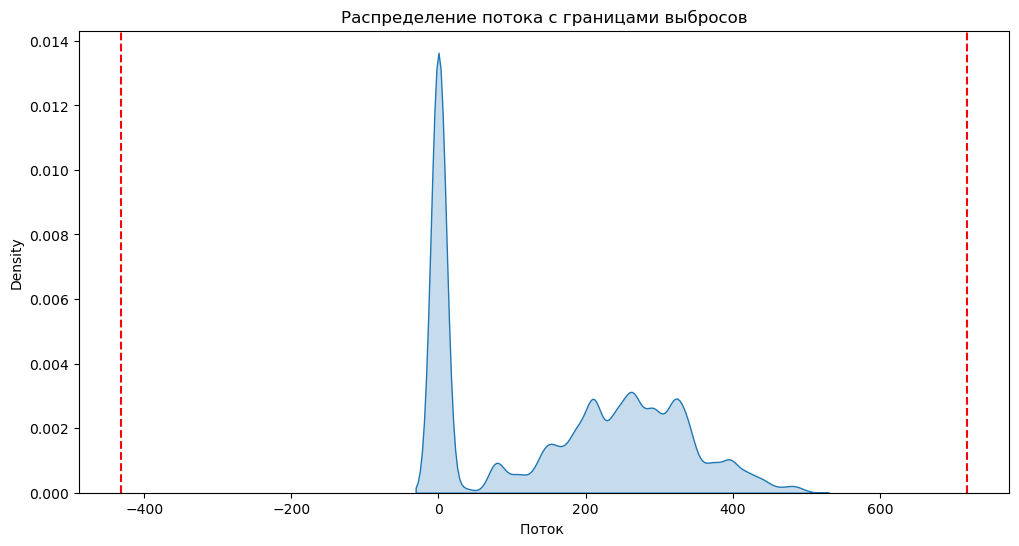

In [83]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Поток ', fill=True)
plt.axvline(x=lower_bound, color='r', linestyle='--', label='Границы выбросов')
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.title('Распределение потока с границами выбросов')

### Корреляция параметров в датафрейме без параметров, у которых было огромное количество пустых значений

Text(0.5, 1.0, 'Корреляция параметров')

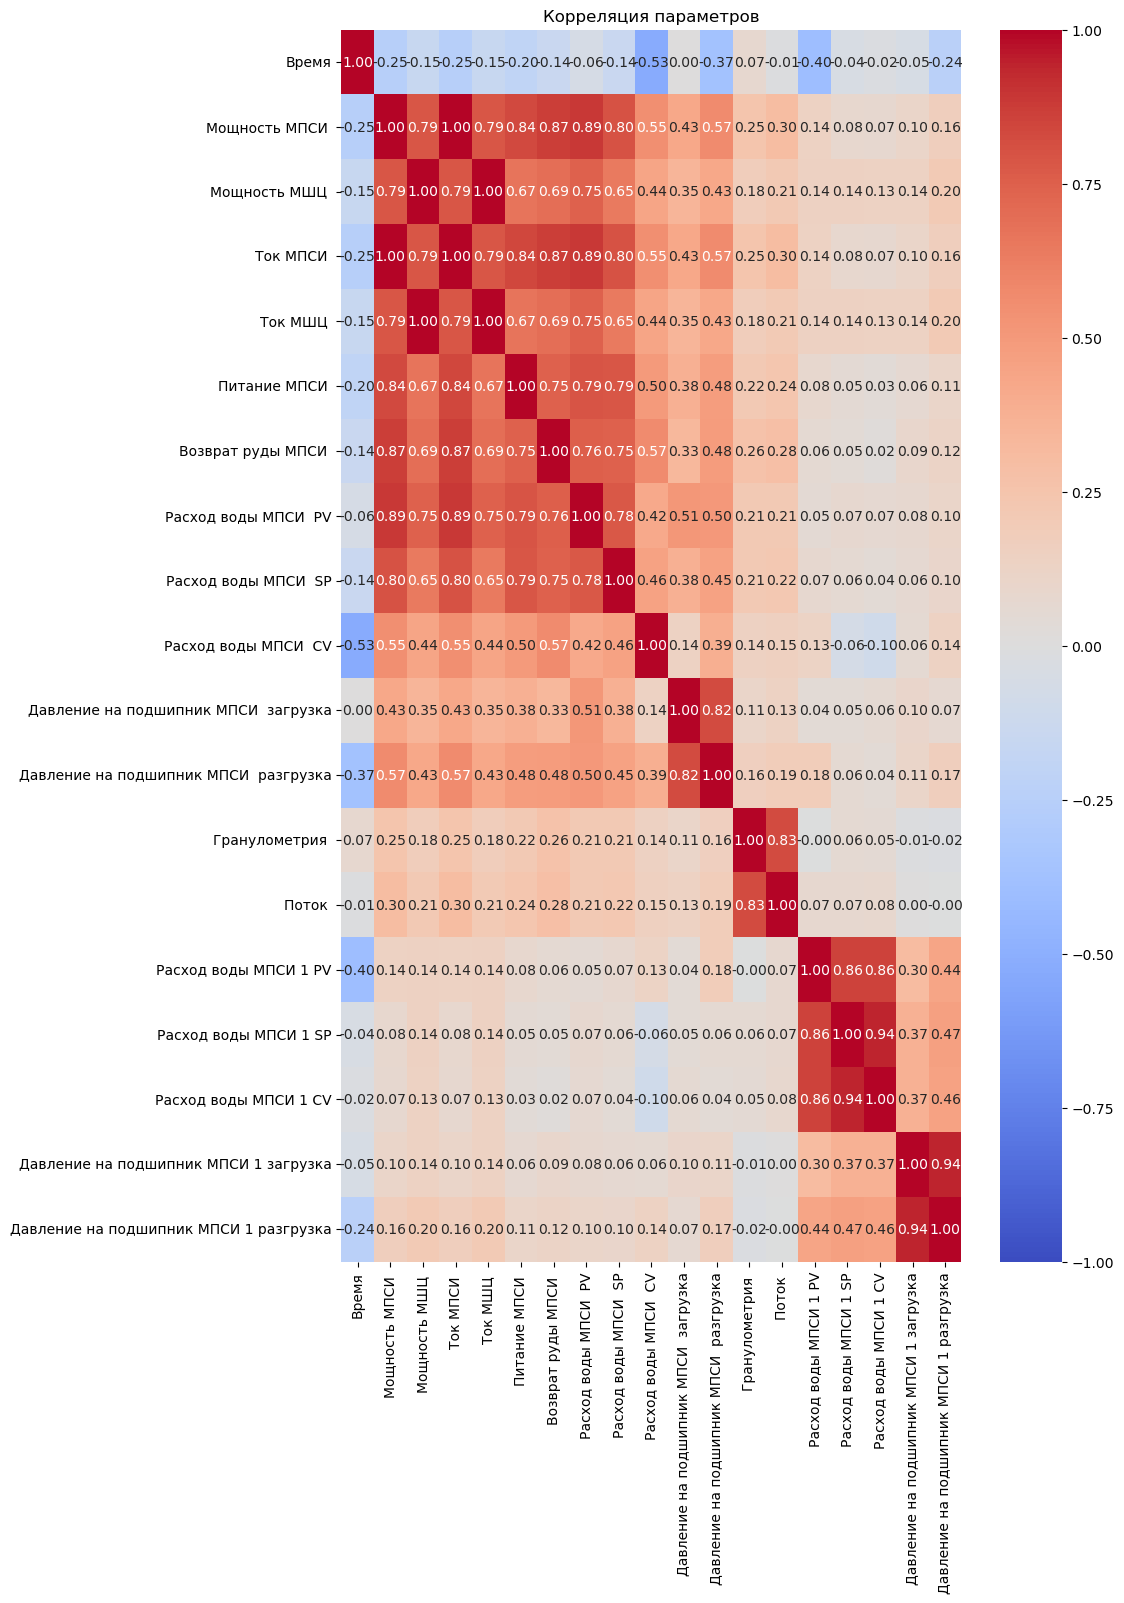

In [130]:
correlation_matrix = cln_df.corr()

plt.figure(figsize=(10, 16))

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1)        

plt.title('Корреляция параметров')


### Наибольшее влияние на гранулометрию (целевую переменную) оказывает Поток

#### В тесте на нормальное распределение мы заметили, что распределение значительно отличается от нормального, поэтому попробуем различные способы преобразования данных

#### 1. Исходные данные


Исходные данные:
p-value: 0.0000000000


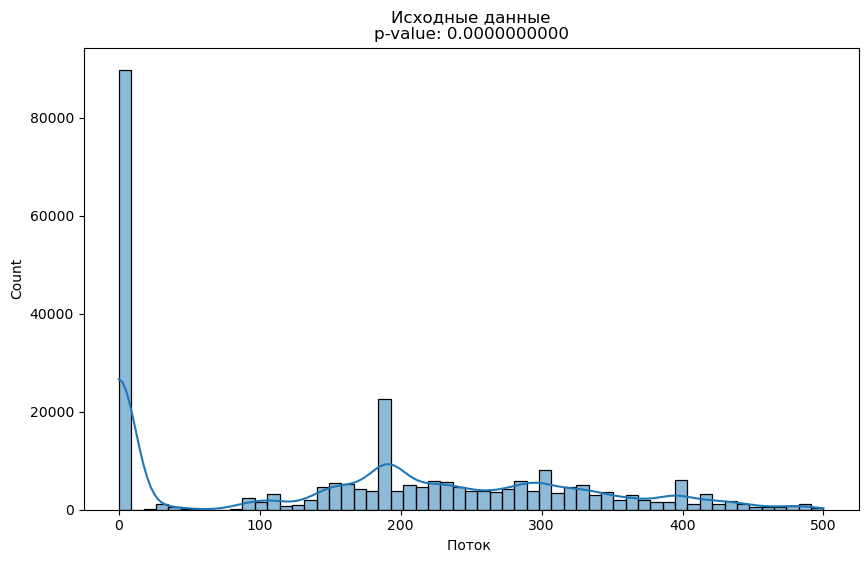

In [131]:
original_pvalue = stats.normaltest(cln_df['Поток '].dropna())[1]
print("\nИсходные данные:")
print(f"p-value: {original_pvalue:.10f}")

plt.figure(figsize=(10, 6))
sns.histplot(cln_df['Поток '], kde=True)
plt.title(f'Исходные данные\np-value: {original_pvalue:.10f}')
plt.show()

#### Удалим значение в 0

In [157]:
cln_df['Поток '].max()

499.9892272949219

In [158]:
cln_df['Поток '].min()

0.0097300428897142

In [163]:
cln_df = cln_df[cln_df['Поток '] != 0]

#### 1. Логарифмическое преобразование


Логарифмическое преобразование:
p-value: 0.0000000000


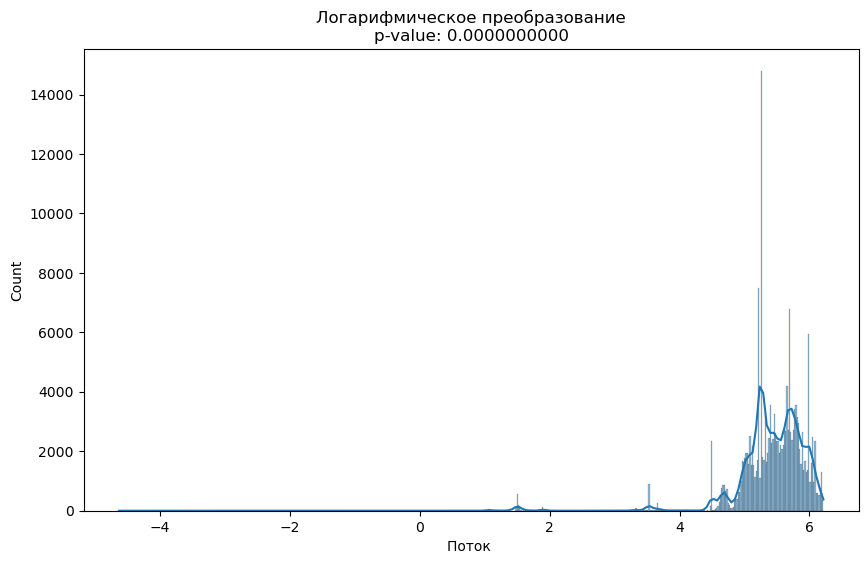

In [155]:
log_data = np.log(cln_df['Поток '])
log_pvalue = stats.normaltest(log_data.dropna())[1]
print("\nЛогарифмическое преобразование:")
print(f"p-value: {log_pvalue:.10f}")
    
plt.figure(figsize=(10, 6))
sns.histplot(log_data, kde=True)
plt.title(f'Логарифмическое преобразование\np-value: {log_pvalue:.10f}')
plt.show()

#### 2. Квадратный корень


Преобразование квадратным корнем:
p-value: 0.0000000000


Text(0.5, 1.0, 'Преобразование квадратным корнем\np-value: 0.0000000000')

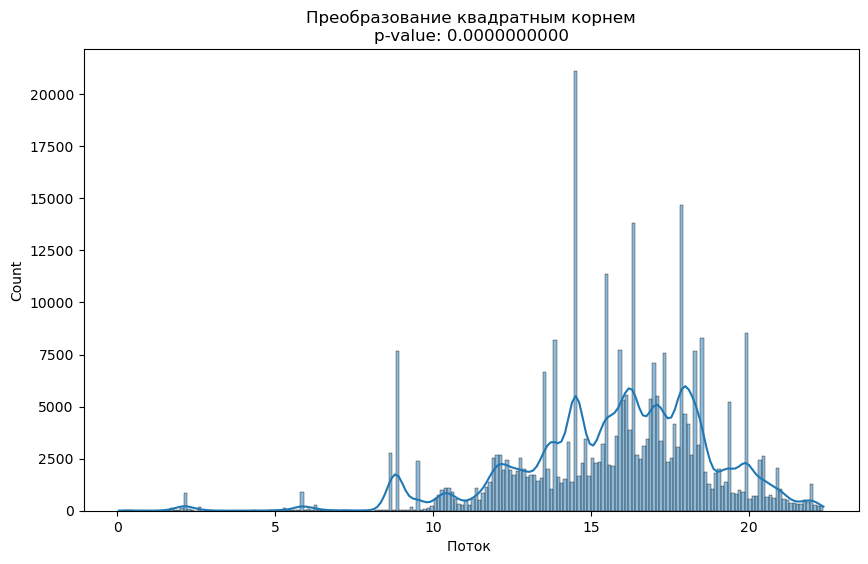

In [116]:
sqrt_data = np.sqrt(cln_df['Поток '])
sqrt_pvalue = stats.normaltest(sqrt_data.dropna())[1]
print("\nПреобразование квадратным корнем:")
print(f"p-value: {sqrt_pvalue:.10f}")

plt.figure(figsize=(10, 6))
sns.histplot(sqrt_data, kde=True)
plt.title(f'Преобразование квадратным корнем\np-value: {sqrt_pvalue:.10f}')

#### 3. Box-Cox преобразование


Box-Cox преобразование:
p-value: 0.0000000000
lambda: 0.8284


Text(0.5, 1.0, 'Box-Cox преобразование\np-value: 0.0000000000')

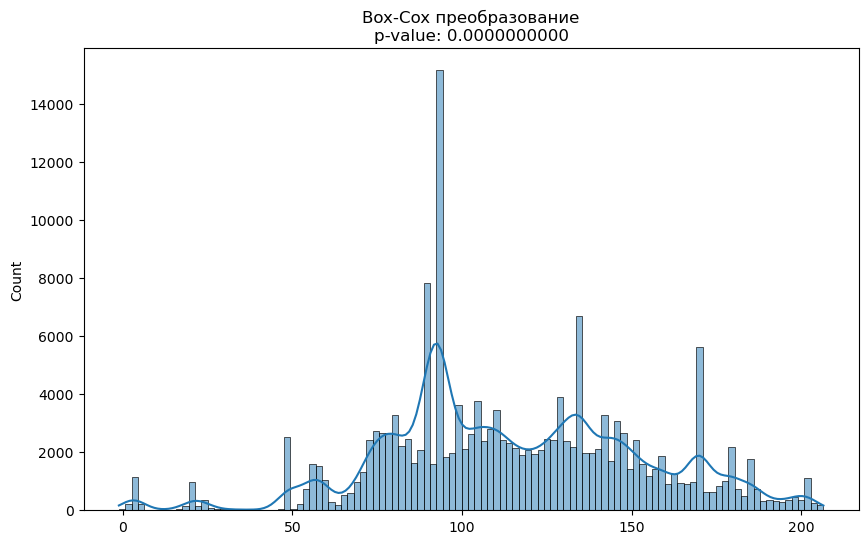

In [ ]:
cln_df = cln_df[cln_df['Поток '] > 0]
boxcox_data, lambda_param = stats.boxcox(cln_df['Поток '])
boxcox_pvalue = stats.normaltest(boxcox_data)[1]
print("\nBox-Cox преобразование:")
print(f"p-value: {boxcox_pvalue:.10f}")
print(f"lambda: {lambda_param:.4f}")
    
plt.figure(figsize=(10, 6))
sns.histplot(boxcox_data, kde=True)
plt.title(f'Box-Cox преобразование\np-value: {boxcox_pvalue:.10f}')

#### 4. Yeo-Johnson преобразование


Yeo-Johnson преобразование:
p-value: 0.0000000000
lambda: 0.8294


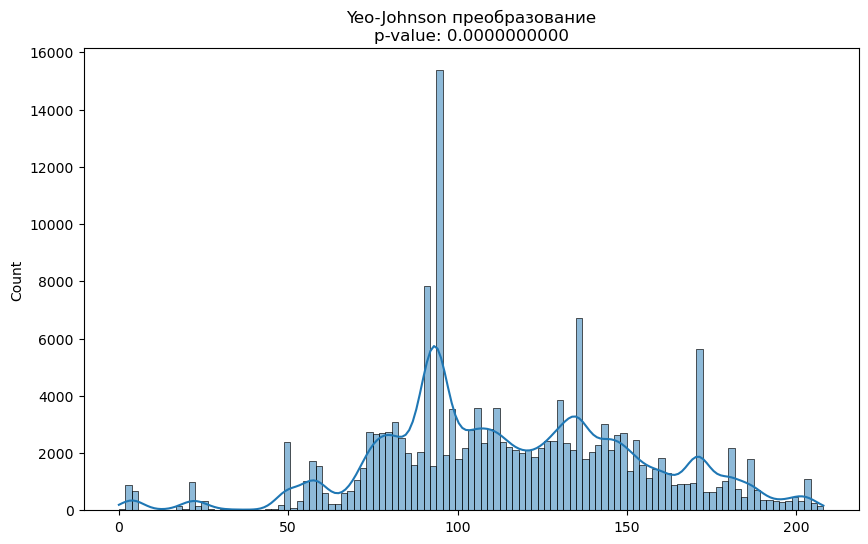

In [142]:
yeojohnson_data, lambda_param = stats.yeojohnson(cln_df['Поток '])
yeojohnson_pvalue = stats.normaltest(yeojohnson_data)[1]
print("\nYeo-Johnson преобразование:")
print(f"p-value: {yeojohnson_pvalue:.10f}")
print(f"lambda: {lambda_param:.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(yeojohnson_data, kde=True)
plt.title(f'Yeo-Johnson преобразование\np-value: {yeojohnson_pvalue:.10f}')
plt.show()

Text(0.5, 1.0, 'Робастное масштабирование')

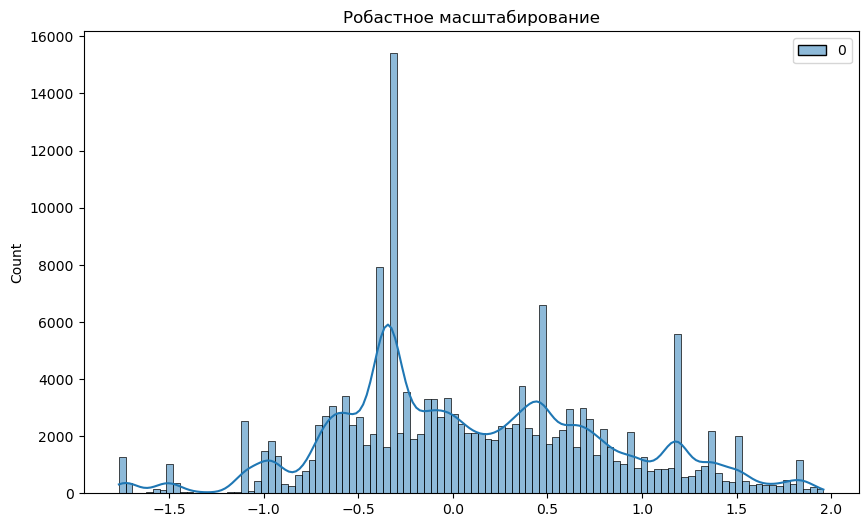

In [145]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(cln_df[['Поток ']])
scaled_pvalue = stats.normaltest(scaled_data)[1]

plt.figure(figsize=(10, 6))
sns.histplot(scaled_data, kde=True)
plt.title('Робастное масштабирование')

#### 6. Обработка выбросов методом IQR

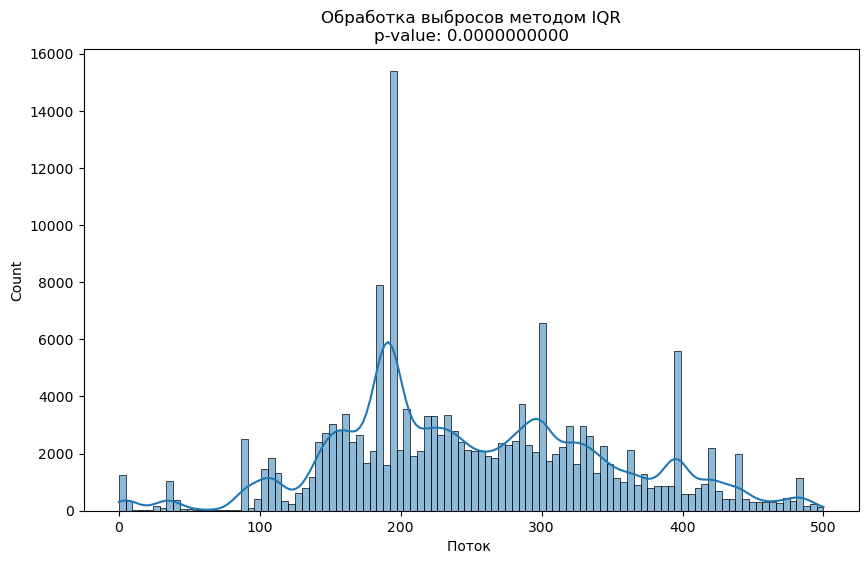

In [ ]:
Q1 = cln_df['Поток '].quantile(0.25)
Q3 = cln_df['Поток '].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_data_iqr = cln_df['Поток '].clip(lower_bound, upper_bound)
cleaned_iqr_pvalue = stats.normaltest(cleaned_data_iqr)[1]

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data_iqr, kde=True)
plt.title(f'Обработка выбросов методом IQR\np-value: {cleaned_iqr_pvalue:.10f}')
plt.show()

#### 7. Обработка выбросов методом z-score

Text(0.5, 1.0, 'Обработка выбросов методом Z-score\np-value: 0.0000000000')

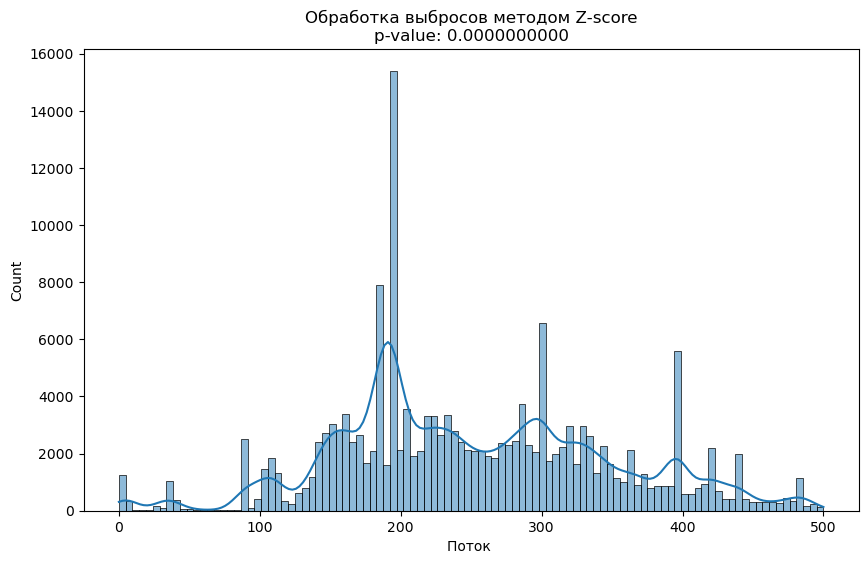

In [151]:
z_scores = np.abs(stats.zscore(cln_df['Поток ']))
cleaned_data_zscore = cln_df['Поток '].mask(z_scores > 3, cln_df['Поток '].median())
cleaned_zscore_pvalue = stats.normaltest(cleaned_data_zscore)[1]

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data_zscore, kde=True)
plt.title(f'Обработка выбросов методом Z-score\np-value: {cleaned_zscore_pvalue:.10f}')

### Сравнение результатов всех методов

In [167]:
results = {
    'Исходные данные': original_pvalue,
    'Логарифм': log_pvalue if cln_df['Поток '].min() > 0 else None,
    'Квадратный корень': sqrt_pvalue if cln_df['Поток '].min() > 0 else None,
    'Box-Cox': boxcox_pvalue if cln_df['Поток '].min() > 0 else None,
    'Yeo-Johnson': yeojohnson_pvalue,
    'Робастное масштабирование': scaled_pvalue,
    'IQR': cleaned_iqr_pvalue,
    'Z-score': cleaned_zscore_pvalue
}


# Определение лучшего метода
best_method = max(results.items(), key=lambda x: x[1] if x[1] is not None else -np.inf)
print(f"\nЛучший метод: {best_method[0]} (p-value: {best_method[1]:.10f})")

if best_method[1] < 0.05:
    print("\nРаспределение все еще не нормальное. Рекомендуется использовать непараметрические методы.")
else:
    print("\nУспешная нормализация данных.")


Лучший метод: Box-Cox (p-value: 0.0000000000)

Распределение все еще не нормальное. Рекомендуется использовать непараметрические методы.


## p values равно 0 я хз что с этим делать

# Оценка важности параметров для предсказания Гранулометрии

In [168]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [172]:
# Преобразуем столбец 'Время' в datetime
cln_df['Время'] = pd.to_datetime(cln_df['Время'])

In [175]:
# Добавим дополнительные временные признаки
cln_df['Час'] = cln_df['Время'].dt.hour
cln_df['День'] = cln_df['Время'].dt.day
cln_df['Месяц'] = cln_df['Время'].dt.month
cln_df['День_недели'] = cln_df['Время'].dt.dayofweek

In [177]:
X = cln_df.drop(['Гранулометрия '], axis=1)
y = cln_df['Гранулометрия ']

In [179]:
# Преобразуем данные в числовой формат
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [180]:
print("Типы данных в признаках:")
print(X.dtypes)

Типы данных в признаках:
Время                                       int64
Мощность МПСИ                             float64
Мощность МШЦ                              float64
Ток МПСИ                                  float64
Ток МШЦ                                   float64
Питание МПСИ                              float64
Возврат руды МПСИ                         float64
Расход воды МПСИ  PV                      float64
Расход воды МПСИ  SP                      float64
Расход воды МПСИ  CV                      float64
Давление на подшипник МПСИ  загрузка      float64
Давление на подшипник МПСИ  разгрузка     float64
Поток                                     float64
Расход воды МПСИ 1 PV                     float64
Расход воды МПСИ 1 SP                     float64
Расход воды МПСИ 1 CV                     float64
Давление на подшипник МПСИ 1 загрузка     float64
Давление на подшипник МПСИ 1 разгрузка    float64
Час                                         int32
День                     

In [181]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

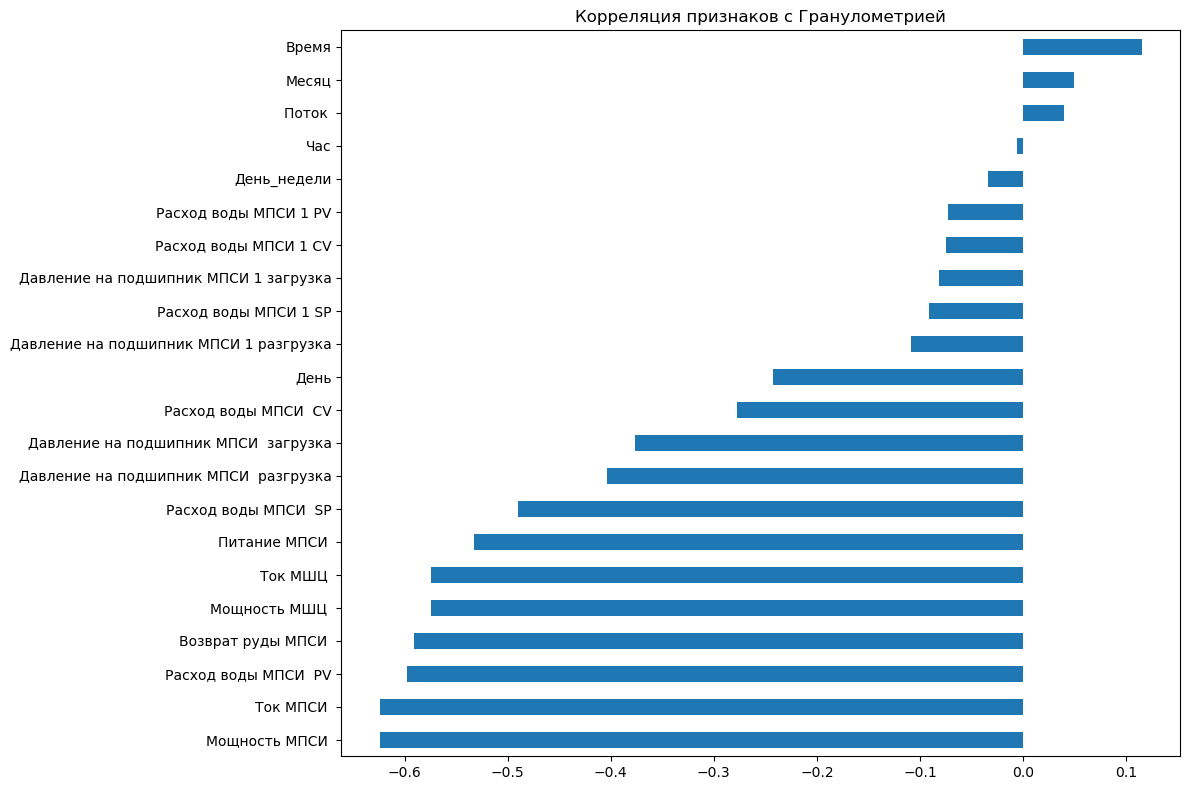

Топ-5 признаков по корреляции:
Расход воды МПСИ 1 PV    0.073304
Месяц                    0.049219
Поток                    0.039887
День_недели              0.033940
Час                      0.005594
dtype: float64


In [186]:
#  Корреляционный анализ на топ
plt.figure(figsize=(12, 8))
correlations = X.corrwith(y).sort_values(ascending=True)
correlations.plot(kind='barh')
plt.title('Корреляция признаков с Гранулометрией')
plt.tight_layout()
plt.show()

print('Топ-5 признаков по корреляции:')
print(correlations.abs().sort_values(ascending=False).tail(5))


## Рандом форестнадо сделать

In [190]:
#  Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_scaled, y)

# Важность признаков из Gradient Boosting
gb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
})
gb_importance = gb_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=gb_importance)
plt.title('Важность признаков (Gradient Boosting)')
plt.tight_layout()
plt.show()

print("\nТоп-10 признаков по Gradient Boosting:")
print(gb_importance.head(10))

KeyboardInterrupt: 

In [ ]:
# Сравнение результатов разных методов
importance_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': abs(correlations),
    'Random_Forest': rf_model.feature_importances_,
    'Gradient_Boosting': gb_model.feature_importances_
})


In [ ]:

# Нормализация значений важности
for col in ['Correlation', 'Random_Forest', 'Gradient_Boosting']:
    importance_comparison[col] = importance_comparison[col] / importance_comparison[col].sum()


In [ ]:

# Сортировка по среднему значению важности
importance_comparison['Mean_Importance'] = importance_comparison[['Correlation', 'Random_Forest', 'Gradient_Boosting']].mean(axis=1)
importance_comparison = importance_comparison.sort_values('Mean_Importance', ascending=False)


In [ ]:

# Визуализация сравнения методов
plt.figure(figsize=(15, 10))
importance_comparison_melted = pd.melt(importance_comparison[['Feature', 'Correlation', 'Random_Forest', 'Gradient_Boosting']], 
                                     id_vars=['Feature'], 
                                     var_name='Method', 
                                     value_name='Importance')


In [ ]:

sns.barplot(x='Importance', y='Feature', hue='Method', 
            data=importance_comparison_melted)
plt.title('Сравнение важности признаков по разным методам')
plt.tight_layout()
plt.show()


In [ ]:

print("\nИтоговый рейтинг признаков (среднее по всем методам):")
print(importance_comparison[['Feature', 'Mean_Importance']].head(10))


In [ ]:

# 6. Анализ взаимосвязей между важными признаками
top_features = importance_comparison['Feature'].head(10).tolist()
correlation_matrix = X[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляции между топ-10 важными признаками')
plt.tight_layout()
plt.show()


In [ ]:

# 7. Scatter plots для топ признаков
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Зависимости Гранулометрии от важных признаков')

for i, feature in enumerate(top_features[:4]):
    row = i // 2
    col = i % 2
    sns.scatterplot(data=cln_df, x=feature, y='Гранулометрия ', ax=axes[row, col])
    axes[row, col].set_title(f'{feature}')

plt.tight_layout()
plt.show()


In [ ]:

# 8. Дополнительная статистика по важным признакам
print("\nСтатистика по топ-10 важным признакам:")
print(X[top_features].describe())


In [ ]:

# 9. Анализ нелинейных зависимостей для топ признаков
for feature in top_features[:4]:
    plt.figure(figsize=(10, 6))
    sns.regplot(data=cln_df, x=feature, y='Гранулометрия ', 
                scatter_kws={'alpha':0.5}, 
                line_kws={'color': 'red'})
    plt.title(f'Зависимость Гранулометрии от {feature}')
    plt.show()